The material in this notebook follows part 2 of Andrej Karpathy's excellent Makemore tutorial (https://www.youtube.com/watch?v=TCH_1BHY58I)


The model we construct in this notebook is based on the following work:

 __Bengio, Y., Ducharme, Ré., Vincent, P. & Janvin, C. (2003). A Neural Probabilistic Language Model. J. Mach. Learn. Res., 3, 1137--1155.__

While this paper operates at the word level for a vocabulary of words, we will operate at the character level. For consistency of notation, however, we will refer to words and vocabulary as in the reference above. 

One of the key ideas here, that is not a component of the bigram models in Part 1, is that the words $w_i$ of a vocabulary $\mathcal{V}$ are embedded into a continuous vector space of dimension $d$. The reason for doing this is that we cannot do numerical computations with characters or other symbols. The above paper refers to this as a "distributed representation" of the vocabularly, and the embedding vectors are learned through the training process.

As before, the models we build are parameterized probability models. For example, if we have a context window of $n$ words, the model we build is for the probability $\mathbb{P}(w_1,...,w_n)$, where $w_i \in \mathcal{V}$ is the $i$-th word within that context. Without further assumptions, however, the number of parameters explodes exponentially. For example, suppose $N=|\mathcal{V}|$. Then, $\mathbb{P}(w_1,...,w_n)$ has $N^n-1$ free parameters -- each entry of $\mathbb{P}(w_1,...,w_n)$, subject to the constraints that $\mathbb{P}(w_1,...,w_n) \geq 0$ and $\sum_{w_1}...\sum_{w_n} \mathbb{P}(w_1,...,w_n) = 1$. Essentially the model has to lie on the probability simplex in an $N^n$ dimensional space.

Note that the probability model $\mathbb{P}(w_1,...,w_n)$ can be equivalently factorized as:

\begin{equation}
\mathbb{P}(w_1,...,w_n) = \prod_{t=1}^n \mathbb{P}(w_t | w_{1:t-1}) 
\end{equation}

where $w_{1:t-1} = (w_1,...,w_{t-1})$. 

In the bigram setting, we simplified things by factorizing $\mathbb{P}(w_1,...,w_n)$ as a markov model: $\mathbb{P}(w_1,...,w_n) = \mathbb{P}(w_1) \mathbb{P}(w_2|w_1)... \mathbb{P}(w_n|w_{n-1})$. Further assuming things are stationary leads to only needing to model $\mathbb{P}(w_i|w_{i-1})$, which has $N^2-1$ free parameters. But as we saw in Part 1 of the tutorial, bigram models do not work well. Larger context is needed.

To that end, in the above reference, the authors construct the following probability model for a fixed context of length $n$:

\begin{equation}
\begin{aligned}
\mathbb{P}(w_t | w_{1:t-1}) &= f_\theta (w_t,w_{t-1}...,w_{t-n+1}) \\
&= g_\theta (w_t, C(w_{t-1}),...,C(w_{t-n+1}),
\end{aligned}
\end{equation}

where $C(w_i) \in \mathbb{R}^d$ is the embedding of word $w_i$ ($C$ may be viewed as a matrix of size $(d,N)$. In the above expression, $g$ is the neural network.


As such, $\mathbb{P}(w_1,...,w_n) = \prod_{t=1}^n f(w_t,...,w_{t-n+1})$ where words $w_{k}$ for $k \leq 0$ are assigned a null token (we used '.' in Part 1). Having the fixed context is important as it implies we can use a standard MLP architecture with $n$ inputs. If the embedding dimension is $d$, then the input to the MLP is a concatenated vector of size $nd$. 

In [90]:
import numpy as np
import torch
import matplotlib.pyplot as plt

!git clone https://github.com/karpathy/makemore

fatal: destination path 'makemore' already exists and is not an empty directory.


In [2]:
with open('makemore/names.txt','r') as file:
  words = file.read().splitlines()

In [3]:
word_lengths = [len(w) for w in words]
print(
 f"""
 This dataset contains {len(word_lengths)} names\n
 The minimum name length is {min(word_lengths)} characters.\n 
 The maximum name length is {max(word_lengths)} characters.\n
 The mean name length is  {np.mean(word_lengths):.2f} characters. \n
 The associated standard deviation is {np.std(word_lengths):.2f} characters.
 """
 )


 This dataset contains 32033 names

 The minimum name length is 2 characters.
 
 The maximum name length is 15 characters.

 The mean name length is  6.12 characters. 

 The associated standard deviation is 1.44 characters.
 


In [4]:
#lookup tables
chars = ['.']+sorted(list(set(''.join(words))))  #as before, '.' is used as a start/stop/padding special character
s_to_i = {s:i for i,s in enumerate(chars)}
i_to_s = {i:s for s,i in s_to_i.items()}

In [143]:
# constructing the dataset

block_size = 3 #context length, size of the block that supports the prediction: P(x_n| x_{n-1}, x_{n-2}, x_{n-3} )
X,Y = [], []

for w in words:
  #print(w)
  context = [0] * block_size #init context using indices of chars
  for ch in w+'.':
    ix = s_to_i[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(i_to_s[i] for i in context), '--->', i_to_s[ix]) #context ---> current, training pattern
    context = context[1:]+[ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [47]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [48]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [26, 26, 25],
        [26, 25, 26],
        [25, 26, 24]])

In [49]:
d = 2 #dimension of the vector space into which characters are embedded
C = torch.randn(27,d) #random embedding

In [50]:
emb = C[X] #simultaneously embed each token/index in X
emb.shape

torch.Size([228146, 3, 2])

In [51]:
W1 = torch.randn((block_size*d,100))
b1 = torch.randn(100)

In [52]:
h = torch.tanh(emb.view((-1,block_size*d)) @ W1 + b1) #-1 tells pytorch to derive this index

In [53]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [54]:
logits = h @ W2 + b2

In [14]:
counts = logits.exp()

In [15]:
prob = counts / counts.sum(1, keepdim=True)

In [16]:
prob.shape

torch.Size([32, 27])

In [17]:
loss = -prob[torch.arange(32), Y].log().mean() # nll loss

In [ ]:
# ----------- consolidating  ---------------#

In [144]:
def build_dataset(words):
  block_size = 3 #context length, size of the block that supports the prediction: P(x_n| x_{n-1}, x_{n-2}, x_{n-3} )
  X,Y = [], []

  for w in words:
    #print(w)
    context = [0] * block_size #init context using indices of chars
    for ch in w+'.':
      ix = s_to_i[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(i_to_s[i] for i in context), '--->', i_to_s[ix]) #context ---> current, training pattern
      context = context[1:]+[ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape,Y.shape)
  return X,Y

#training split (used to train parameters), dev/validation split (used to train hyperparameters), test split (at end with the final model)
# 80%, 10%, 10%
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [149]:
import torch.nn.functional as F
from tqdm import tqdm

In [168]:
#initialize all parameters
d = 10 #embedding dimension
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,d), generator=g) #embedding matrix
W1 = torch.randn((6,300), generator=g) #layer 1 
b1 = torch.randn(300, generator=g) #layer 1
W2 = torch.randn((300,27), generator=g) #layer 2
b2 = torch.randn(27, generator=g) #layer 2
parameters = [C,W1,b1,W2,b2] # all params

In [169]:
# number of parameters
sum(p.nelement() for p in parameters)

10281

In [170]:
for p in parameters:
  p.requires_grad = True

In [153]:
## Here we are investigating different learning rates in our training
# The desired learning rate is one that is as large as possible without making the training unstable
# To do this we start with small learning rates and gradually increase them
# By starting with small learning rates, we drive the loss down. By increasing the learning rate,
# we probe at what stage the steps become to big. 

lr = 0.1
n_iter = 30000

lre = torch.linspace(-3,0,n_iter) # increasing learning rate exponents 
lrs = 10**lre 


lri = []
lossi = []
stepi = []

for i in tqdm(range(n_iter)):

  #construct minibatch indices
  ix = torch.randint(0,Xtr.shape[0],(32,)) 

  # forward pass
  emb = C[Xtr[ix]] #embedding characters
  h = torch.tanh(emb.view(-1,6) @ W1 + b1) #(32,100)
  logits = h @ W2 + b2 #(32,27)
  # counts = logits.exp()
  # probs = counts / counts.sum(1, keepdims=True)
  # loss = - prob[torch.arange(32), Y].log().mean()
  loss = F.cross_entropy(logits, Ytr[ix]) #does a lot of things under the hood to improve numerical stability

  #backward pass
  for p in parameters:
    p.grad = None #"zeroing" out any old parameter gradients
  loss.backward() 

  #update
  lr = lrs[i]
  for p in parameters:
    p.data += -lr * p.grad

  #track stats
  lri.append(lre[i])
  lossi.append(loss.item())
print(loss.item()) #loss of the last minibatch


7.77862024307251


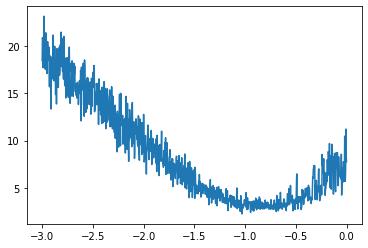

In [154]:
plt.plot(lri,lossi)

This experiment suggests that a learning rate of around $10^{-1}$ is reasonable to pick. So, we restart with this learning rate.

In [198]:
#initialize all parameters
d = 10 #embedding dimension
block_size = 3 #determined in the dataset construction

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,d), generator=g) #embedding matrix
W1 = torch.randn((block_size*d,200), generator=g) #layer 1 
b1 = torch.randn(200, generator=g) #layer 1
W2 = torch.randn((200,27), generator=g) #layer 2
b2 = torch.randn(27, generator=g) #layer 2
parameters = [C,W1,b1,W2,b2] # all params

for p in parameters:
  p.requires_grad = True

In [199]:
lossi = []
stepi = []


In [209]:
#lr = 0.1

lr = 0.01 #decay  in the latter stage of training by raising to a power 
n_iter = 100000

for i in tqdm(range(n_iter)):

  #construct minibatch indices
  ix = torch.randint(0,Xtr.shape[0],(32,)) 

  # forward pass
  emb = C[Xtr[ix]] #embedding characters
  h = torch.tanh(emb.view(-1,d*block_size) @ W1 + b1) #(32,100)
  logits = h @ W2 + b2 #(32,27)
  loss = F.cross_entropy(logits, Ytr[ix])

  #backward pass
  for p in parameters:
    p.grad = None
  loss.backward() 

  #update
  for p in parameters:
    p.data += -lr * p.grad

  lossi.append(loss.log10().item())
  stepi.append(i)

100%|██████████| 100000/100000 [00:54<00:00, 1842.18it/s]


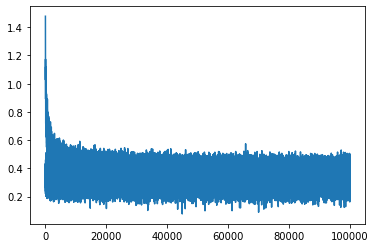

In [210]:
plt.plot(stepi,lossi) #training loss

In [211]:
# training loss
emb = C[Xtr] #embedding characters
h = torch.tanh(emb.view(-1,block_size*d) @ W1 + b1) #(32,100)
logits = h @ W2 + b2 #(32,27)
loss = F.cross_entropy(logits, Ytr)

print(f'train loss: {loss.item()}')

train loss: 2.083164691925049


In [212]:
# loss on the full dataset
emb = C[Xdev] #embedding characters
h = torch.tanh(emb.view(-1,block_size*d) @ W1 + b1) #(32,100)
logits = h @ W2 + b2 #(32,27)
loss = F.cross_entropy(logits, Ydev)

print(f'dev loss: {loss.item()}')

dev loss: 2.1397197246551514


In [213]:
# visualizing the embedding vectors
# this is only possible when have selected d=2
if d == 2:
  plt.figure(figsize=(8,8))
  plt.scatter(C[:,0].data, C[:,1].data, s=200)
  for i in range(C.shape[0]):
    plt.text(C[i,0].item(),C[i,1].item(), i_to_s[i], ha="center", va="center", color='white' )
  plt.grid('minor')

In [217]:
#Sampling from the model (it is a distribution over word sequences after all)
g = torch.Generator().manual_seed(2147483647 + 11)

for _ in range(20):

  out = []
  context = [0] * block_size #starting context window ... (1,block_size)
  while True:
    emb=C[torch.tensor([context])] # (1, block_size, d)
    h = torch.tanh(emb.view(1,-1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits,dim=1) # get the output distribution on the characters
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:]+[ix] #shifts the context window to the right one character (now includes ix)
    out.append(ix)
    if ix == 0: #terminate at character '.'
      break
  print(''.join(i_to_s[i] for i in out))

naharlone.
hamarma.
tyriya.
zakhadlyn.
vibat.
aryelynnette.
tyre.
van.
kaj.
aalah.
jakhizabellouanna.
hay.
olah.
niver.
ana.
katanzine.
yosen.
avart.
serena.
jody.
